In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("combined_data.csv", index_col=[0, 1])
df

Inflation  Population           GDP      Export  \
Country Code Year                                                     
ABW          1980         NaN     59909.0           NaN         NaN   
             1981         NaN     60563.0           NaN         NaN   
             1982         NaN     61276.0           NaN         NaN   
             1983         NaN     62228.0           NaN         NaN   
             1984         NaN     62901.0           NaN         NaN   
...                       ...         ...           ...         ...   
ZWE          2017    0.893962  14812482.0  5.107466e+10  107.151887   
             2018   10.618866  15034452.0  3.415607e+10  124.909506   
             2019  255.304991  15271368.0  2.571741e+10  131.425343   
             2020  557.201817  15526888.0  2.686794e+10  135.325610   
             2021   98.546105  15797210.0  2.724052e+10  185.806800   

                       Import  
Country Code Year              
ABW          1980         NaN  
             1981         NaN  
             1982         NaN  
             1983         NaN  
             1984         NaN  
...                       ...  
ZWE          2017   83.660837  
             2018  105.579357  
             2019   79.585840  
             2020   82.633621  
             2021  118.756526  

[7686 rows x 5 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7686 entries, ('ABW', 1980) to ('ZWE', 2021)
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Inflation   6524 non-null   float64
 1   Population  7676 non-null   float64
 2   GDP         7317 non-null   float64
 3   Export      6718 non-null   float64
 4   Import      6718 non-null   float64
dtypes: float64(5)
memory usage: 329.7+ KB


In [4]:
df = df.dropna(subset = ['GDP'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7317 entries, ('ABW', 1986) to ('ZWE', 2021)
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Inflation   6488 non-null   float64
 1   Population  7317 non-null   float64
 2   GDP         7317 non-null   float64
 3   Export      6648 non-null   float64
 4   Import      6648 non-null   float64
dtypes: float64(5)
memory usage: 314.2+ KB


In [6]:
df = df.drop(index = [("AFG", 2020), ("AFG", 2021)])

In [7]:
df.isnull().sum()

Inflation     827
Population      0
GDP             0
Export        669
Import        669
dtype: int64

In [8]:
df['Inflation_Missing_Status'] = np.where(df['Inflation'].isna(), 'Missed', 'Not Missed')

In [9]:
df['Export_Missing_Status'] = np.where(df['Export'].isna(), 'Missed', 'Not Missed')

In [10]:
df['Import_Missing_Status'] = np.where(df['Import'].isna(), 'Missed', 'Not Missed')

In [11]:
df

Inflation  Population           GDP      Export  \
Country Code Year                                                     
ABW          1986    1.073966     59931.0  4.055866e+08  105.022708   
             1987    3.643045     59159.0  4.877095e+08  115.503652   
             1988    3.121868     59331.0  5.966480e+08  135.066427   
             1989    3.991628     60443.0  6.955307e+08  101.349267   
             1990    5.836688     62753.0  7.648045e+08  123.596991   
...                       ...         ...           ...         ...   
ZWE          2017    0.893962  14812482.0  5.107466e+10  107.151887   
             2018   10.618866  15034452.0  3.415607e+10  124.909506   
             2019  255.304991  15271368.0  2.571741e+10  131.425343   
             2020  557.201817  15526888.0  2.686794e+10  135.325610   
             2021   98.546105  15797210.0  2.724052e+10  185.806800   

                       Import Inflation_Missing_Status Export_Missing_Status  \
Country Code Year                                                              
ABW          1986   47.432669               Not Missed            Not Missed   
             1987   58.364675               Not Missed            Not Missed   
             1988   83.150974               Not Missed            Not Missed   
             1989   95.561922               Not Missed            Not Missed   
             1990  132.571551               Not Missed            Not Missed   
...                       ...                      ...                   ...   
ZWE          2017   83.660837               Not Missed            Not Missed   
             2018  105.579357               Not Missed            Not Missed   
             2019   79.585840               Not Missed            Not Missed   
             2020   82.633621               Not Missed            Not Missed   
             2021  118.756526               Not Missed            Not Missed   

                  Import_Missing_Status  
Country Code Year                        
ABW          1986            Not Missed  
             1987            Not Missed  
             1988            Not Missed  
             1989            Not Missed  
             1990            Not Missed  
...                                 ...  
ZWE          2017            Not Missed  
             2018            Not Missed  
             2019            Not Missed  
             2020            Not Missed  
             2021            Not Missed  

[7315 rows x 8 columns]

In [12]:
df_imputed = df.copy()

In [13]:
len(df.index.get_level_values("Country Code").unique())

183

# Handeling missing values with WLS

In [14]:
import statsmodels.api as sm

for country in df.index.get_level_values("Country Code").unique(): 
    country_df = df.xs(country, level="Country Code") 
    for column in df.columns:  
        valid_data = country_df.dropna(subset=[column])  
        missing_data = country_df[country_df[column].isna()]  

        if missing_data.empty:
            continue  

        X_valid = valid_data.index.values.reshape(-1, 1)  
        y_valid = valid_data[column].values   
        X_missing = missing_data.index.values.reshape(-1, 1)  

    
        X_valid_wls = sm.add_constant(X_valid)

        
        weights = 1 / (np.abs(X_valid - X_missing.T) + 1) ** 2  

        
        model = sm.WLS(y_valid, X_valid_wls, weights.mean(axis=1))
        results = model.fit()

        X_missing_wls = np.ones((X_missing.shape[0], X_valid_wls.shape[1]))  
        X_missing_wls[:, -1] = X_missing.ravel()  
    
        predicted_values = results.predict(X_missing_wls)

        df.loc[(country, missing_data.index), column] = predicted_values

In [15]:
df

Inflation  Population           GDP      Export  \
Country Code Year                                                     
ABW          1986    1.073966     59931.0  4.055866e+08  105.022708   
             1987    3.643045     59159.0  4.877095e+08  115.503652   
             1988    3.121868     59331.0  5.966480e+08  135.066427   
             1989    3.991628     60443.0  6.955307e+08  101.349267   
             1990    5.836688     62753.0  7.648045e+08  123.596991   
...                       ...         ...           ...         ...   
ZWE          2017    0.893962  14812482.0  5.107466e+10  107.151887   
             2018   10.618866  15034452.0  3.415607e+10  124.909506   
             2019  255.304991  15271368.0  2.571741e+10  131.425343   
             2020  557.201817  15526888.0  2.686794e+10  135.325610   
             2021   98.546105  15797210.0  2.724052e+10  185.806800   

                       Import Inflation_Missing_Status Export_Missing_Status  \
Country Code Year                                                              
ABW          1986   47.432669               Not Missed            Not Missed   
             1987   58.364675               Not Missed            Not Missed   
             1988   83.150974               Not Missed            Not Missed   
             1989   95.561922               Not Missed            Not Missed   
             1990  132.571551               Not Missed            Not Missed   
...                       ...                      ...                   ...   
ZWE          2017   83.660837               Not Missed            Not Missed   
             2018  105.579357               Not Missed            Not Missed   
             2019   79.585840               Not Missed            Not Missed   
             2020   82.633621               Not Missed            Not Missed   
             2021  118.756526               Not Missed            Not Missed   

                  Import_Missing_Status  
Country Code Year                        
ABW          1986            Not Missed  
             1987            Not Missed  
             1988            Not Missed  
             1989            Not Missed  
             1990            Not Missed  
...                                 ...  
ZWE          2017            Not Missed  
             2018            Not Missed  
             2019            Not Missed  
             2020            Not Missed  
             2021            Not Missed  

[7315 rows x 8 columns]

In [16]:
df.isnull().sum()

Inflation                   0
Population                  0
GDP                         0
Export                      0
Import                      0
Inflation_Missing_Status    0
Export_Missing_Status       0
Import_Missing_Status       0
dtype: int64

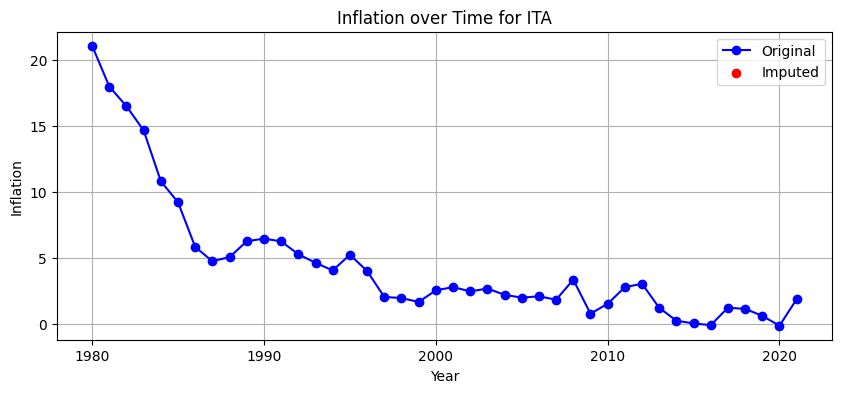

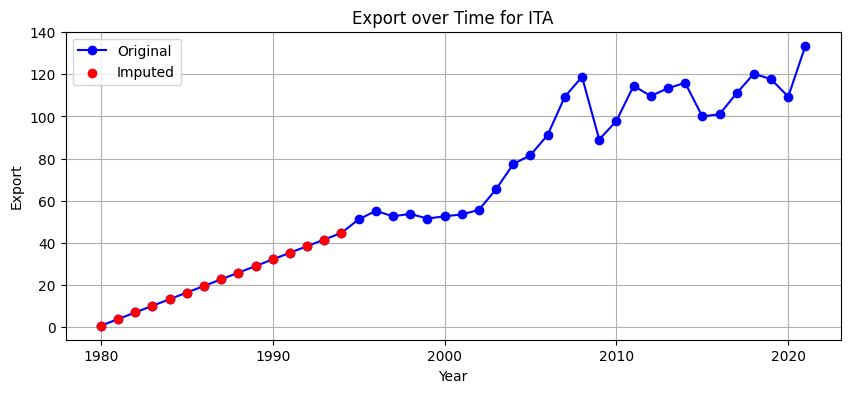

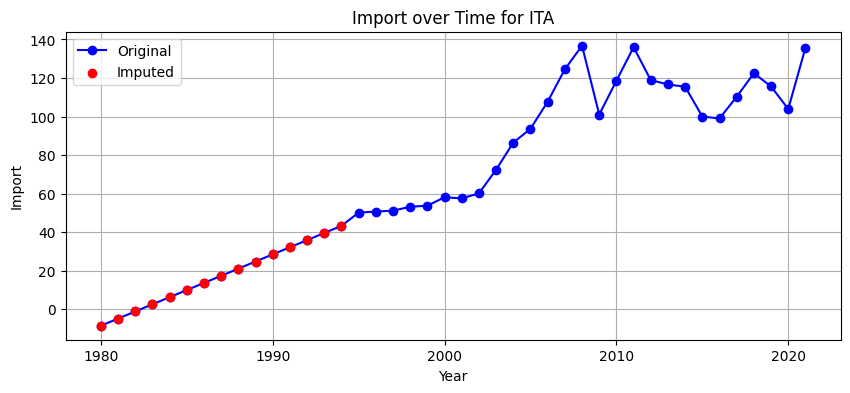

In [17]:
country_code = "ITA"  


features = ['Inflation', 'Export', 'Import']

if country_code in df.index.get_level_values(0).unique():
    country_data = df.loc[country_code]

    for feature in features:

        missing_col = f'{feature}_Missing_Status'

        missing_mask = country_data[missing_col] == 'Missed'

        plt.figure(figsize=(10, 4))
        plt.plot(country_data.index, country_data[feature], label='Original', color='blue', marker='o', linestyle='-')
        plt.scatter(country_data.index[missing_mask], country_data[feature][missing_mask], 
                    color='red', label='Imputed', zorder=3)

        plt.title(f"{feature} over Time for {country_code}")
        plt.xlabel("Year")
        plt.ylabel(feature)
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print(f"Country code '{country_code}' not found in dataset.")


In [18]:
df

Inflation  Population           GDP      Export  \
Country Code Year                                                     
ABW          1986    1.073966     59931.0  4.055866e+08  105.022708   
             1987    3.643045     59159.0  4.877095e+08  115.503652   
             1988    3.121868     59331.0  5.966480e+08  135.066427   
             1989    3.991628     60443.0  6.955307e+08  101.349267   
             1990    5.836688     62753.0  7.648045e+08  123.596991   
...                       ...         ...           ...         ...   
ZWE          2017    0.893962  14812482.0  5.107466e+10  107.151887   
             2018   10.618866  15034452.0  3.415607e+10  124.909506   
             2019  255.304991  15271368.0  2.571741e+10  131.425343   
             2020  557.201817  15526888.0  2.686794e+10  135.325610   
             2021   98.546105  15797210.0  2.724052e+10  185.806800   

                       Import Inflation_Missing_Status Export_Missing_Status  \
Country Code Year                                                              
ABW          1986   47.432669               Not Missed            Not Missed   
             1987   58.364675               Not Missed            Not Missed   
             1988   83.150974               Not Missed            Not Missed   
             1989   95.561922               Not Missed            Not Missed   
             1990  132.571551               Not Missed            Not Missed   
...                       ...                      ...                   ...   
ZWE          2017   83.660837               Not Missed            Not Missed   
             2018  105.579357               Not Missed            Not Missed   
             2019   79.585840               Not Missed            Not Missed   
             2020   82.633621               Not Missed            Not Missed   
             2021  118.756526               Not Missed            Not Missed   

                  Import_Missing_Status  
Country Code Year                        
ABW          1986            Not Missed  
             1987            Not Missed  
             1988            Not Missed  
             1989            Not Missed  
             1990            Not Missed  
...                                 ...  
ZWE          2017            Not Missed  
             2018            Not Missed  
             2019            Not Missed  
             2020            Not Missed  
             2021            Not Missed  

[7315 rows x 8 columns]

In [19]:
len(df.index.get_level_values('Country Code').unique())

183

In [20]:
df.to_csv('df_handeled missing values_with_WLS.csv')

# Handling missing values with Multiple Imputation

In [21]:
df_imputed.isnull().sum()

Inflation                   827
Population                    0
GDP                           0
Export                      669
Import                      669
Inflation_Missing_Status      0
Export_Missing_Status         0
Import_Missing_Status         0
dtype: int64

In [22]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Ridge

columns_to_impute = ["Inflation", "Export", "Import"]

imputer = IterativeImputer(estimator= Ridge(10), max_iter=10, random_state=42)

for country in df_imputed.index.get_level_values("Country Code").unique():
    country_df = df_imputed.xs(country, level="Country Code")  

    if country_df[columns_to_impute].isna().sum().sum() == 0:
        continue 

    imputed_values = imputer.fit_transform(country_df[columns_to_impute])

    df_imputed.loc[country, columns_to_impute] = imputed_values


In [23]:
df_imputed.isnull().sum()

Inflation                   0
Population                  0
GDP                         0
Export                      0
Import                      0
Inflation_Missing_Status    0
Export_Missing_Status       0
Import_Missing_Status       0
dtype: int64

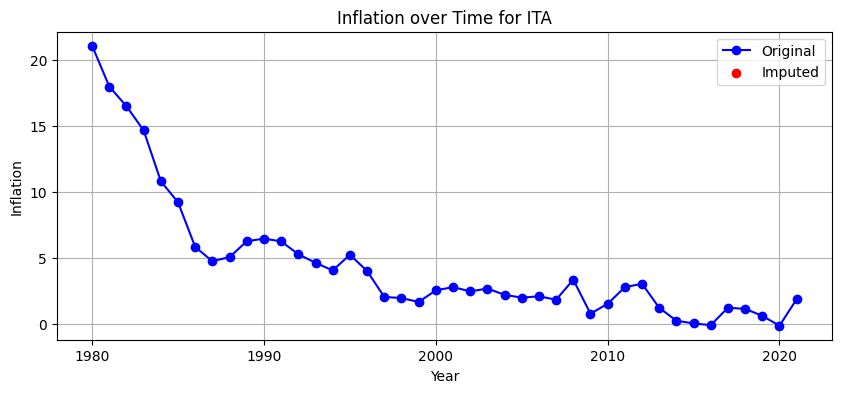

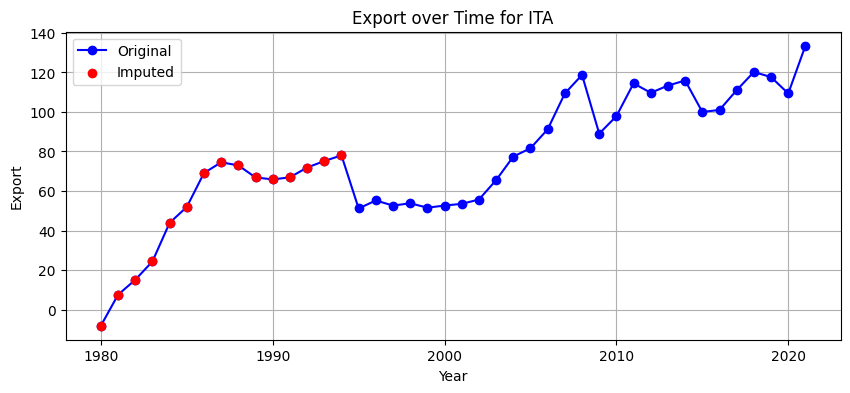

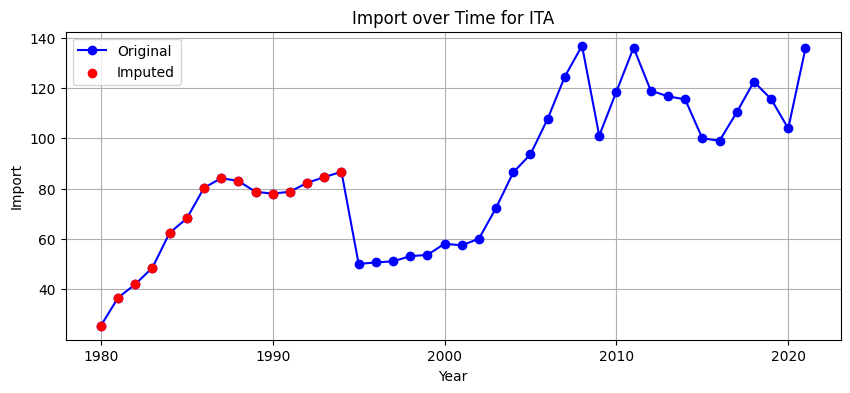

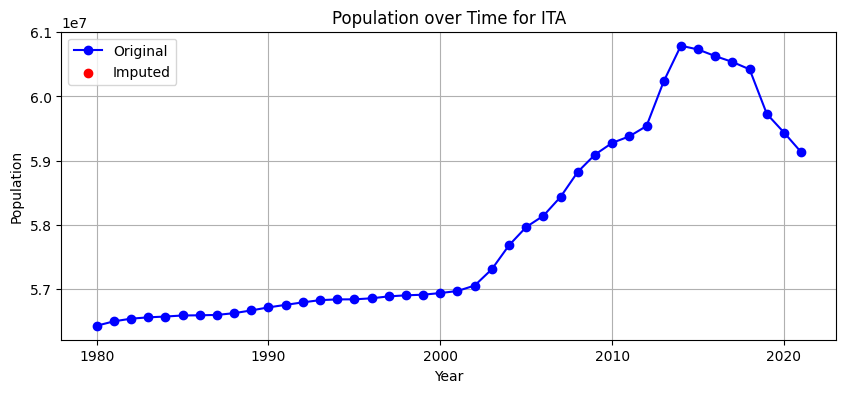

In [24]:
import matplotlib.pyplot as plt

country_code = "ITA"  
features = ['Inflation', 'Export', 'Import', 'Population']  

if country_code in df_imputed.index.get_level_values(0).unique():
    country_data = df_imputed.loc[country_code] 

    for feature in features:
        missing_col = f'{feature}_Missing_Status'

        if missing_col in country_data.columns:
            missing_mask = country_data[missing_col] == 'Missed'
        else:
            missing_mask = country_data[feature].isna()  

        plt.figure(figsize=(10, 4))
        plt.plot(country_data.index, country_data[feature], label='Original', color='blue', marker='o', linestyle='-')
        plt.scatter(country_data.index[missing_mask], country_data[feature][missing_mask], 
                    color='red', label='Imputed', zorder=3)

        plt.title(f"{feature} over Time for {country_code}")
        plt.xlabel("Year")
        plt.ylabel(feature)
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print(f"Country code '{country_code}' not found in dataset.")


In [25]:
df.to_csv('df_handeled missing values_with_multipleImputation.csv')